# Devoir 2: Romain SOLIMAN et Enzo BENBALIT 

In [1]:
#importation des packages python

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import brentq
import math

In [2]:
sns.set_theme(style="darkgrid")

## $$\underline{\text{EXERCICE 2}}$$


### A)

In [3]:
def BSOptionPrice(S, K, r, T_t, sigma, isPut):
    # Cette fonction donne en sortie le prix d'une option vanille européenne sous le modèle de Black-Scholes
     
    # Calcul de d1 et d2 dans le modèle de BS
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T_t) / (sigma * np.sqrt(T_t))
    d2 = d1 - sigma * np.sqrt(T_t)

    if isPut:
        # la formule de Black-Scholes dans le cas d'un Put
        option_price = K * np.exp(-r * T_t) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        # la formule de Black-Scholes dans le cas d'un Call
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T_t) * norm.cdf(d2)

    return option_price

### B)

In [4]:
S = 100
K = 105
r = 0.02
T = 0.5
sigma = 0.2

évaluation_achat=BSOptionPrice(S, K, r, T, sigma, isPut=False) # Pour le CALL
évaluation_vente=BSOptionPrice(S, K, r, T, sigma, isPut=True)  # Pour le PUT

print(f"le prix d'une option d'achat est {round(évaluation_achat,2)}")
print(f"le prix d'une option de vente est {round(évaluation_vente,2)}")

le prix d'une option d'achat est 3.99
le prix d'une option de vente est 7.94


### C)

In [5]:
def BSImplicitVol(Option_price, S, K, r, T_t, isPut):
    # retourne la volatilité implicite d'une option vanille européenne par une méthode d'optimisation (ici on utilise brentq)
    # on trouve le sigma qui minimise la différence entre le prix du marché oobservé et la formule de B-S

    # function à minimiser
    def f(sigma):
        return BSOptionPrice(S, K, r, T_t, sigma, isPut) - Option_price

    # l'interval où sigma varie
    sigma_min, sigma_max = 0.001, 2.0

    # on optimise
    implied_vol = brentq(f, sigma_min, sigma_max)

    return implied_vol

### D)

In [6]:
Option_price=2.7852
S=100
K=105
r=0.02
T=0.25

implicite_achat=BSImplicitVol(Option_price,S, K, r, T, isPut=False)
print(f"la volatilité implicite pour l'option d'achat est {round(implicite_achat,3)}")


la volatilité implicite pour l'option d'achat est 0.23


In [7]:
Option_price=6.8249
S=100
K=105
r=0.02
T=0.75

implicite_vente=BSImplicitVol(Option_price,S, K, r, T, isPut=True)
print(f"la volatilité implicite pour l'option de vente est {round(implicite_vente,3)}")

la volatilité implicite pour l'option de vente est 0.14


## $$\underline{\text{EXERCICE 3}}$$


### A)

In [8]:
def BinOptionPrice(S0,K,T,r,sigma,mu,N,isPut):
    # nous retourne la valeur approché du prix d'une option vanille européenne par l'arbre binomial
    
    #pas de temps h 
    dt= T/N
    R= math.exp(r*dt)
    
    u=math.exp(mu*dt + sigma*math.sqrt(dt)) # coefficient Up
    d=math.exp(mu*dt - sigma*math.sqrt(dt)) # coefficient Down
    q = (R-d)/(u-d)                         #probabilité risque neutre
    
    S= np.zeros((N+1,N+1))
    for j in range(N+1):
        for i in range(N+1):
            S[j-i,j] = S0* u**i *d**(j-i)  #les chemins que peut prendre notre actif
    
    V = np.zeros((N+1,N+1))
    for j in reversed(range(N+1)):         # on itère back-ward
        for i in range(j+1):
            if(j==N and not isPut):
                V[i,j] = max(S[i,j]-K,0)   # la valeur terminal si c'est un Call
            elif(j==N and isPut):
                V[i,j] = max(K-S[i,j],0)   # la valeur terminal si c'est un Put
            else : 
                V[i,j] = (q*V[i,j+1]+(1-q)*V[i+1,j+1])/R  

    return V[0,0]    

### B)


In [9]:
S0 = 100
K = 105
r = 0.02
T = 0.5
sigma = 0.2
mu = (r-(sigma**2)/2)
N=20

Call_option_bin = BinOptionPrice(S0,K,T,r,sigma,mu,N,False)
print(f"L'estimation par le modèle binomial du prix d'un Call européen est {round(Call_option_bin,3)} pour N={N}")
print(f"la vrai valeur d'un Call européen sous le modèle B-S est {round(évaluation_achat,2)}")

L'estimation par le modèle binomial du prix d'un Call européen est 4.012 pour N=20
la vrai valeur d'un Call européen sous le modèle B-S est 3.99


### C)

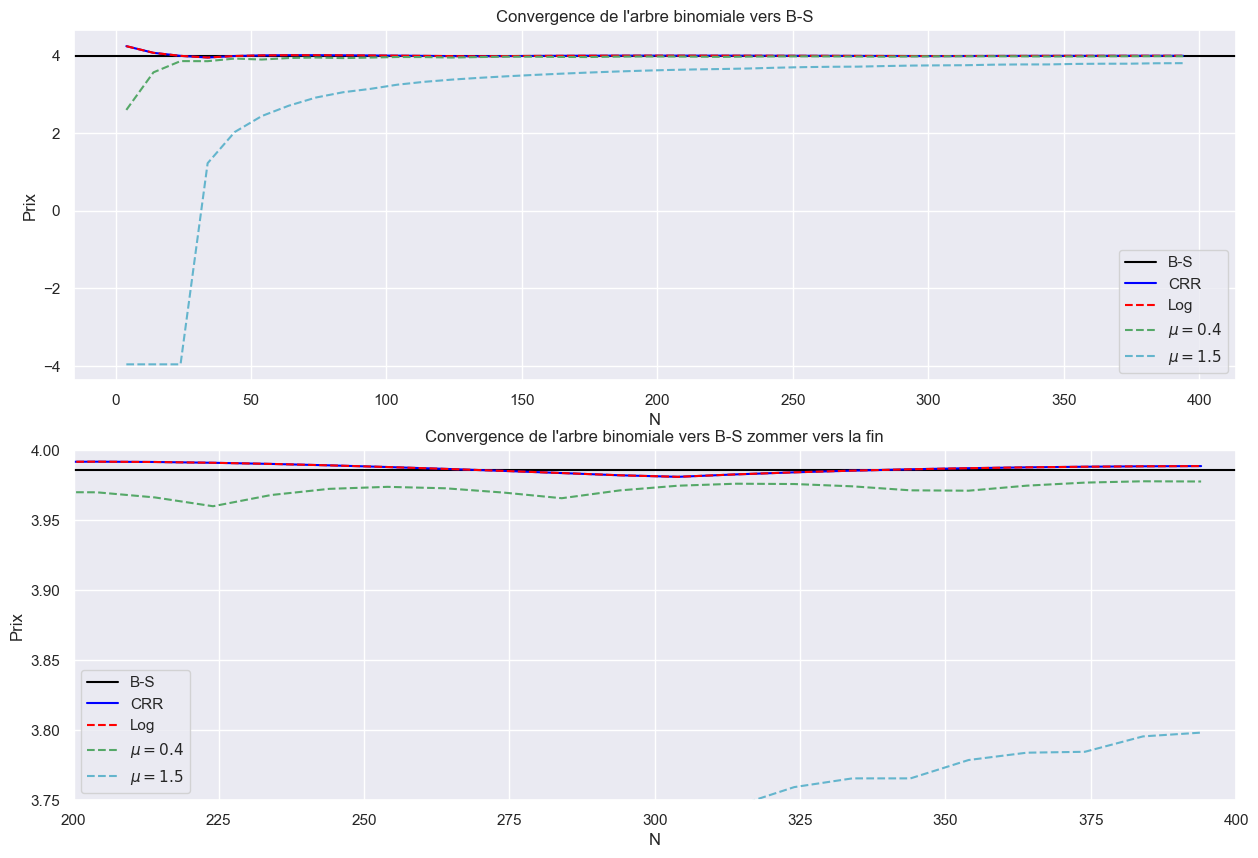

In [10]:
S0 = 100
K = 105
r = 0.02
T = 0.5
sigma = 0.2
isPut = False

mu_log = (r-(sigma**2)/2) # mu dans l'arbre log-normale
mu_CRR = 0                # mu dans l'arbre CRR
mu_1 = 0.4
mu_2 = 1.5

N=list(range(4,400,10))  

CRR = [BinOptionPrice(S0,K,T,r,sigma,mu_CRR,i,isPut) for i in N] # liste des prix sous CRR pour différents n
Log = [BinOptionPrice(S0,K,T,r,sigma,mu_log,i,isPut) for i in N] # liste des prix sous log pour différents n
Bin1 = [BinOptionPrice(S0,K,T,r,sigma,mu_1,i,isPut) for i in N]
Bin2 = [BinOptionPrice(S0,K,T,r,sigma,mu_2,i,isPut) for i in N]

prix_Black_Scholes = BSOptionPrice(S, K, r, T, sigma, isPut)

fig, axs = plt.subplots(2,1,figsize=(15,10))

# affichage du prix Black-Scholes
axs[0].axhline(prix_Black_Scholes,color='black', label='B-S')

# affichage de la convergence pour CRR
axs[0].plot(N,CRR,label='CRR',color='blue')

# affichage de la convergence pour log
axs[0].plot(N,Log,label='Log',color='red',linestyle='--')

#affichage de la convergence pour les autres valeurs de mu
axs[0].plot(N,Bin1,label=f'$\mu = {mu_1}$',color='g',linestyle='--')
axs[0].plot(N,Bin2,label=f'$\mu = {mu_2}$',color='c',linestyle='--')

axs[0].set_title("Convergence de l'arbre binomiale vers B-S")
axs[0].set_xlabel("N")
axs[0].set_ylabel("Prix")

axs[0].legend()

# affichage du prix Black-Scholes zoomer vers la fin
axs[1].axhline(prix_Black_Scholes,color='black', label='B-S')

# affichage de la convergence pour CRR zoomer vers la fin
axs[1].plot(N,CRR,label='CRR',color='blue')

# affichage de la convergence pour log zoommer vers la fin
axs[1].plot(N,Log,label='Log',color='red',linestyle='--')

#affichage de la convergence pour les autres valeurs de mu zoomer vers la fin
axs[1].plot(N,Bin1,label=f'$\mu = {mu_1}$',color='g',linestyle='--')
axs[1].plot(N,Bin2,label=f'$\mu = {mu_2}$',color='c',linestyle='--')

axs[1].set_title("Convergence de l'arbre binomiale vers B-S zommer vers la fin")
axs[1].set_xlabel("N")
axs[1].set_ylabel("Prix")
axs[1].set_xlim(200,400)
axs[1].set_ylim(3.75,4)

axs[1].legend()


plt.show()



### D)

La convergence de l'arbre binomiale vers le modèle de Black-Scholes semble plus rapide lorsque $\mu$ est proche de 0. En effet, on observe bien que pour $N=150$, l'arbre de CRR et log-normale est deja très proche de la vrai valeur alors que le prix pour $\mu=1.5$ en est encore très loin.

### E)

In [11]:
S0=100
K=105
r=0.02
T=0.5
sigma = 0.2
N=[2, 3, 10, 10000]
length_n = len(N)

def convergence_lognormal(S0,K,r,T,sigma,n):
    
    h=1/n;
    mu = 0.3
    
    u= np.exp(mu*h+sigma*np.sqrt(h))
    d= np.exp(mu*h-sigma*np.sqrt(h))

    q= (np.exp(r*h)-d)/(u-d)

    Mn=2*q-1
    Vn=1-Mn**2

    mu_n = mu+ sigma*np.sqrt(n)*Mn
    sigma2_n = Vn*sigma**2 
    
    R_t_n = mu_n*T + np.sqrt(sigma2_n*T)*npr.normal(size=1000)
    S_t_n = S0*np.exp(R_t_n)

    return S_t_n

S_t_n = np.zeros((length_n,1000))

for i in range(length_n) :
    S_t_n[i,:] = convergence_lognormal(S0,K,r,T,sigma,N[i])



In [12]:
#densité théorique
x = np.linspace(0,160, 1000)

mu_lognormal = np.log(S0) +(r-(sigma**2)/2)*T
sigma_lognormal = sigma*np.sqrt(T)

pdf = (1 / (x * sigma_lognormal * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu_lognormal)**2) / (2 * sigma_lognormal**2))

/var/folders/3r/959b_c8j293_cdt5_svxcqch0000gn/T/ipykernel_12318/2200631648.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf = (1 / (x * sigma_lognormal * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu_lognormal)**2) / (2 * sigma_lognormal**2))
/var/folders/3r/959b_c8j293_cdt5_svxcqch0000gn/T/ipykernel_12318/2200631648.py:7: RuntimeWarning: divide by zero encountered in log
  pdf = (1 / (x * sigma_lognormal * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu_lognormal)**2) / (2 * sigma_lognormal**2))
/var/folders/3r/959b_c8j293_cdt5_svxcqch0000gn/T/ipykernel_12318/2200631648.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf = (1 / (x * sigma_lognormal * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu_lognormal)**2) / (2 * sigma_lognormal**2))


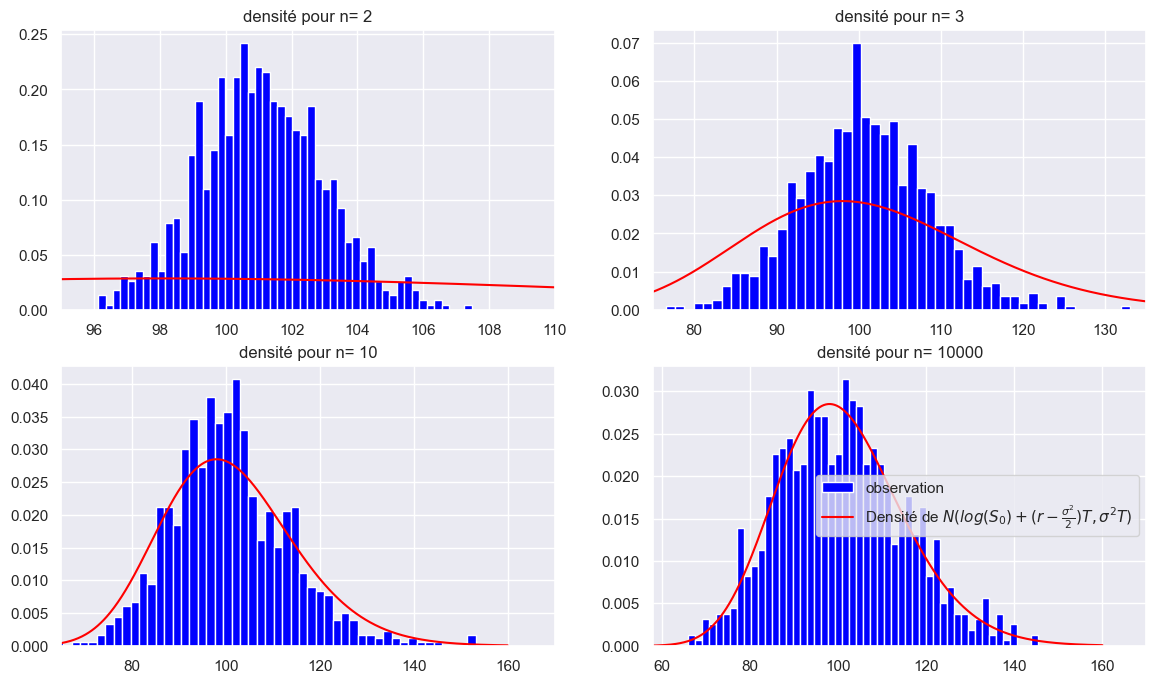

In [13]:
    
fig, axs = plt.subplots(nrows=2,ncols=2,figsize = (14,8))

axs[0,0].hist(S_t_n[0,:], bins=50,density =True, color='blue',label="observation")
axs[0,0].plot(x, pdf, color='red', label='Densité de probabilité théorique')
axs[0,0].set_title(f"densité pour n= {N[0]}")
axs[0,0].set_xlim((95,110))

axs[0,1].hist(S_t_n[1,:], bins=50,density =True, color='blue',label="observation")
axs[0,1].plot(x, pdf, color='red', label='Densité de probabilité théorique')
axs[0,1].set_title(f"densité pour n= {N[1]}")
axs[0,1].set_xlim((75,135))

axs[1,0].hist(S_t_n[2,:], bins=50,density =True, color='blue',label="observation")
axs[1,0].plot(x, pdf, color='red', label='Densité de probabilité théorique')
axs[1,0].set_title(f"densité pour n= {N[2]}")
axs[1,0].set_xlim((65,170))

axs[1,1].hist(S_t_n[3,:], bins=50,density =True, color='blue',label="observation")
axs[1,1].plot(x, pdf, color='red', label=r"Densité de $N(log(S_0)+(r-\frac{\sigma^2}{2})T,\sigma^2 T)$")
axs[1,1].set_title(f"densité pour n= {N[3]}")
axs[1,1].set_xlim((58,170))

plt.legend()
plt.show()

### F)

d'un point de vue numérique, l'utilisation du modèle binomial pour approximer le prix d'option exotiques sous le modèle Black-Scholes n'est généralement pas appropriée, en effet, de nombreuses options exotiques sont path-dependent, c'est-à-dire que leur valeur dépend non seulement du prix final de l'actif sous-jacent, mais également de son comportement durant toute la durée de vie de l'option. Le modèle binomial peut devenir extrêmement complexe et lourd en termes de calculs pour ces types d'options, car il nécessite de suivre et de calculer des chemins de prix multiples à chaque étape de l'arbre. De plus, avec une augmentation du nombre d'étapes dans l'arbre binomial, le coût computationnel augmente exponentiellement, en particulier pour les options path-dependent.

## $$\underline{\text{EXERCICE 4}}$$


### A)

In [14]:
def SimulateStockPaths(S0, mu, r, sigma, nsteps, sizesteps, npaths, theseed, isPmeasure):
    # retourne une matrice Stock_paths de taille npaths*(nsteps+1) qui contient npaths chemin de l'actif S
    
    # on instancie la seed 
    npr.seed(theseed)  
    dt = sizesteps  # Taille d'un pas de temps
    
    # calcul du Drift selon la mesure choisi
    if isPmeasure:
        drift = mu - 0.5 * sigma**2 # Si la mesure est la mesure réelle P
    else :
        drift = r - 0.5 * sigma**2

    # Matrice de taille npaths*(nsteps+1) pour stocker les trajectoires simulées
    Stock_paths = np.zeros((npaths, nsteps + 1))
    Stock_paths[:, 0] = S0  # Valeur initiale pour toutes les trajectoires

    
    for t in range(1, nsteps + 1):
        # Génère des variations aléatoires
        normal_realisation = np.random.normal(0, 1, npaths)
        # Calcule le prochain pas pour chaque trajectoire
        Stock_paths[:, t] = Stock_paths[:, t - 1] * np.exp(drift * dt + sigma * np.sqrt(dt) * normal_realisation)

    return Stock_paths

### B)

In [15]:
def SimulateStockPathsAntithetic(S0, mu, r, sigma, nsteps, sizesteps, npaths, theseed, isPmeasure):
    # retourne une matrice Stock_paths de taille npaths*(nsteps+1) qui contient npaths chemin de l'actif S
    # dont les la trajectoire M/2+i est anthithétque à la trajectoire i, i ->[1,M]
    
    #on vérifie que le nombre de trajectoire est bien pair
    if npaths % 2 != 0:
        raise ValueError("Le nombre de trajectoires (npaths) doit être pair pour utiliser les variables antithétiques.")

    # on instancie la seed 
    npr.seed(theseed)
    dt = sizesteps
    
    # calcul du Drift selon la mesure choisi
    if isPmeasure:
        drift = mu - 0.5 * sigma**2 # Si la mesure est la mesure réelle P
    else :
        drift = r - 0.5 * sigma**2
        
    half_npaths = npaths // 2  # La moitié des trajectoires

    # Matrice pour stocker les trajectoires simulées et leurs antithétiques
    Stock_paths = np.zeros((npaths, nsteps + 1))
    Stock_paths[:, 0] = S0

    for t in range(1, nsteps + 1):
        # Génère des variations aléatoires
        normal_realisation = np.random.normal(0, 1, half_npaths)
        # Calcule le prochain pas pour la première moitié des trajectoires
        Stock_paths[:half_npaths, t] = Stock_paths[:half_npaths, t - 1] * np.exp(drift * dt + sigma * np.sqrt(dt) * normal_realisation)
        # Trajectoires antithétiques pour la deuxième moitié
        Stock_paths[half_npaths:, t] = Stock_paths[half_npaths:, t - 1] * np.exp(drift * dt - sigma * np.sqrt(dt) * normal_realisation)

    return Stock_paths

### C)

In [16]:
S =100               # le prix courant de l'actif risqué
mu = 0.07            # le paramètre mu dans le modèle de Black-Scholes
r = 0.02             # le taux sans risque
sigma = 0.20         # le pramètre sigma dans le modèle de Black-Scholes
T = 0.5              # le temps final
dt = 1/52            # longueur d'un pas de temps
nsteps = int(T/dt)   # le nombre de pas de temps
M = 10000            # le nombre de trajectoires simulées

theseed = 1          # la seed pour reproduire les résultats

StockPathsP = SimulateStockPaths(S, mu, r, sigma, nsteps, dt, M, theseed, True) 
StockPathsQ = SimulateStockPaths(S, mu, r, sigma, nsteps, dt, M, theseed, False)

StockPathsPAntithetic = SimulateStockPathsAntithetic(S, mu, r, sigma, nsteps, dt, M, theseed, True)
StockPathsQAntithetic = SimulateStockPathsAntithetic(S, mu, r, sigma, nsteps, dt, M, theseed, False)

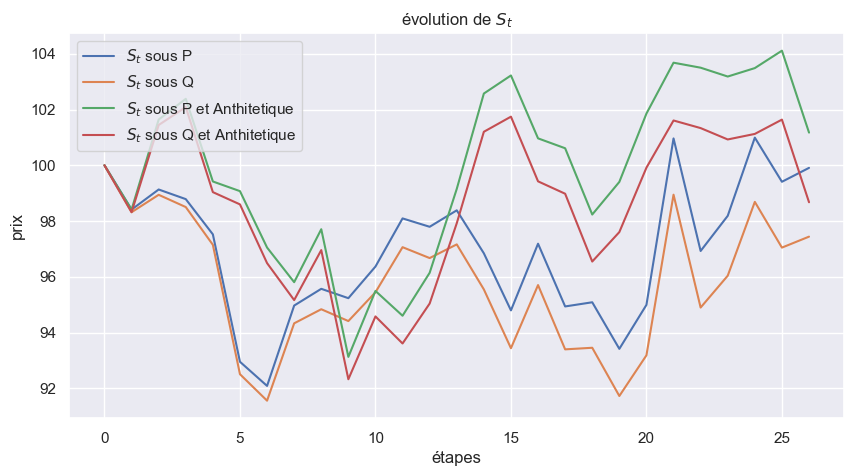

In [17]:
plt.figure(figsize=(10,5))

plt.plot(StockPathsP[1,:],label=f"$S_t$ sous P")
plt.plot(StockPathsQ[1,:],label=f"$S_t$ sous Q")
plt.plot(StockPathsPAntithetic[1,:], label=f"$S_t$ sous P et Anthitetique")
plt.plot(StockPathsQAntithetic[1,:], label=f"$S_t$ sous Q et Anthitetique")

plt.title(f'évolution de $S_t$')
plt.xlabel('étapes')
plt.ylabel('prix')
plt.legend()

$\underline{\text{Observation}}$: Les prix observé sous la mesure Q sont systematiquement inférieurs aux prix observé sous la mesure P

### D)


\begin{align*}
E^P[S_T]&= E^P[S_0e^{(\mu-\frac{\sigma^2}{2})T+\sigma W_T^P}]\\
&= S_0e^{(\mu-\frac{\sigma^2}{2})T}E^P[e^{\sigma W_T^P}]\\
&= S_0e^{(\mu-\frac{\sigma^2}{2})T}e^{\frac{\sigma^2}{2}T}\\
&=S_0e^{\mu T}
\end{align*}

\begin{align*}
E^Q[S_T]&= E^Q[S_0e^{(r-\frac{\sigma^2}{2})T+\sigma W_T^Q}]\\
&= S_0e^{(r-\frac{\sigma^2}{2})T}E^Q[e^{\sigma W_T^Q}]\\
&= S_0e^{(r-\frac{\sigma^2}{2})T}e^{\frac{\sigma^2}{2}T}\\
&=S_0e^{r T}
\end{align*}


In [18]:
est_P_reel = S*np.exp(T*mu)   # E[S_T] réel sous la mesure P
est_Q_reel = S*np.exp(T*r)    # E[S_T] réel sous la mesure Q

print(f'E[S_T] = {round(est_P_reel,2)} sous la mesure P')
print(f'E[S_T] = {round(est_Q_reel,2)} sous la mesure Q')

E[S_T] = 103.56 sous la mesure P
E[S_T] = 101.01 sous la mesure Q


In [19]:
est_P = np.mean(StockPathsP[:,-1])                          # estimation de E[S_T] sous la mesure P par Monte-Carlo
est_Q = np.mean(StockPathsQ[:,-1])                          # estimation de E[S_T] sous la mesure Q par Monte-Carlo

est_P_Anthitetic  = np.mean(StockPathsPAntithetic[:,-1])    # estimation de E[S_T] sous la mesure P par variable anthitetique par Monte-Carlo
est_Q_Anthitetic = np.mean(StockPathsQAntithetic[:,-1])     # estimation de E[S_T] sous la mesure Q par variable anthitetique par Monte-Carlo

print(f'estimation de E[S_T] sous la mesure P: {round(est_P,2)}')
print(f'estimation de E[S_T] sous la mesure Q: {round(est_Q,2)}')
print(f'estimation de E[S_T] sous la mesure P par variables anthitetique: {round(est_P_Anthitetic,2)}')
print(f'estimation de E[S_T] sous la mesure Q par variables anthitetique: {round(est_Q_Anthitetic,2)}')

estimation de E[S_T] sous la mesure P: 103.76
estimation de E[S_T] sous la mesure Q: 101.2
estimation de E[S_T] sous la mesure P par variables anthitetique: 103.55
estimation de E[S_T] sous la mesure Q par variables anthitetique: 100.99


In [20]:
std_P = np.std(StockPathsP[:,-1])                          # estimation de (Var[S_T])^{1/2} sous la mesure P par Monte-Carlo
std_Q = np.std(StockPathsQ[:,-1])                          # estimation de (Var[S_T])^{1/2} sous la mesure Q par Monte-Carlo

std_P_Anthitetic  = np.std(StockPathsPAntithetic[:,-1])    # estimation de (Var[S_T])^{1/2} sous la mesure P par variable anthitetique par Monte-Carlo
std_Q_Anthitetic = np.std(StockPathsQAntithetic[:,-1])     # estimation de (Var[S_T])^{1/2} sous la mesure Q par variable anthitetique par Monte-Carlo

print(f'un intervalle de niveau 95% pour E[S_T] est [{round(est_P-1.96*(std_P/np.sqrt(M)),2)},{round(est_P+1.96*(std_P/np.sqrt(M)),2)}] sous P et avec une méthode classique')
print(f'un intervalle de niveau 95% pour E[S_T] est [{round(est_Q-1.96*(std_Q/np.sqrt(M)),2)},{round(est_Q+1.96*(std_Q/np.sqrt(M)),2)}] sous Q et avec une méthode classique')
print(f'un intervalle de niveau 95% pour E[S_T] est [{round(est_P_Anthitetic-1.96*(std_P_Anthitetic/np.sqrt(M)),2)},{round(est_P_Anthitetic+1.96*(std_P_Anthitetic/np.sqrt(M)),2)}] sous P et avec les variables anthitetiques')
print(f'un intervalle de niveau 95% pour E[S_T] est [{round(est_Q_Anthitetic-1.96*(std_Q_Anthitetic/np.sqrt(M)),2)},{round(est_Q_Anthitetic+1.96*(std_Q_Anthitetic/np.sqrt(M)),2)}] sous Q et avec les variables anthitetiques')

un intervalle de niveau 95% pour E[S_T] est [103.48,104.05] sous P et avec une méthode classique
un intervalle de niveau 95% pour E[S_T] est [100.92,101.48] sous Q et avec une méthode classique
un intervalle de niveau 95% pour E[S_T] est [103.26,103.84] sous P et avec les variables anthitetiques
un intervalle de niveau 95% pour E[S_T] est [100.71,101.27] sous Q et avec les variables anthitetiques


$\underline{\text{Observation}}$: Les simulations par variable anthitetiques sont beaucoup plus précises. En effet, les intervalles de confiance par variables anthitetiques sont inclus dans les intervalle de confiance sans variable anthitetique pour un même niveau de confiance.

## $$\underline{\text{EXERCICE 5}}$$

### A)

In [21]:
S =100               # le prix courant de l'actif risqué
mu = 0.07            # le paramètre mu dans le modèle de Black-Scholes
r = 0.02             # le taux sans risque
sigma = 0.20         # le pramètre sigma dans le modèle de Black-Scholes
T = 0.5              # le temps final
dt = 1/52            # longueur d'un pas de temps
nsteps = int(T/dt)   # le nombre de pas de temps
K = 100              # le strike de l'option

In [22]:
A_T_Q = np.mean(StockPathsQ[:,1:],axis=1)                         # on détermine M-échantillon A_T en somant sur les lignes de la matrice StockPathsQ
A_T_Q_Anthitetic = np.mean(StockPathsQAntithetic[:,1:],axis=1)    # on détermine M-échantillon A_T en somant sur les lignes de la matrice StockPathsQAnthitetic

H_Q = np.maximum(A_T_Q - K ,0)                              # on détermine M-échantillon de H sous Q
H_Q_Anthitetic = np.maximum(A_T_Q_Anthitetic - K,0)         # on détermine M-échantillon de H sous Q par variable Anthitetique

prix_H_Q = np.exp(-r*T)* np.mean(H_Q)                           # on détermine une estimation par Monte-Carlo du prix de l'option Asiatique
prix_H_Q_Anthitetic = np.exp(-r*T)* np.mean(H_Q_Anthitetic)     # on détermine une estimation par Monte-Carlo du prix de l'option Asiatique par variable Anthitetique

std_H_Q = np.std(np.exp(-r*T)*H_Q)                          # écart-type de la série H_Q réactualisé
std_H_Q_Anthitetic = np.std(np.exp(-r*T)*H_Q_Anthitetic)    # écart-type de la série H_Q par variable Anthitetique réactualisé

print(f'Une estimation du prix de l\'option Asiatique est : {round(prix_H_Q,2)}')
print(f'Un intervalle de confiance au niveau 95% pour le prix de l\'option asiatique est [{round(prix_H_Q-1.96*(std_H_Q/np.sqrt(M)),2)},{round(prix_H_Q+1.96*(std_H_Q/np.sqrt(M)),2)}]')
print(f'Une estimation du prix de l\'option Asiatique par variable Anthitetique est : {round(prix_H_Q_Anthitetic,2)}')
print(f'Un intervalle de confiance au niveau 95% pour le prix de l\'option asiatique par variable anthitetique est [{round(prix_H_Q_Anthitetic-1.96*(std_H_Q_Anthitetic/np.sqrt(M)),2)},{round(prix_H_Q_Anthitetic+1.96*(std_H_Q_Anthitetic/np.sqrt(M)),2)}]')



Une estimation du prix de l'option Asiatique est : 3.64
Un intervalle de confiance au niveau 95% pour le prix de l'option asiatique est [3.53,3.74]
Une estimation du prix de l'option Asiatique par variable Anthitetique est : 3.54
Un intervalle de confiance au niveau 95% pour le prix de l'option asiatique par variable anthitetique est [3.44,3.65]


$\underline{\text{Observation}}$: La encore, les simulation par variable anthitetique sont bien plus précise

### B)

Soit $$H^{(ari)}=(A_T^{(ari)}-K)_+$$ avec $$A_T^{(ari)}=\frac{1}{n}\sum_{i=1}^n S_{t_i}$$
nous avons 

\begin{align*}
E^Q[A_T^{(ari)}]&=E^Q[\frac{1}{n}\sum_{i=1}^n S_{t_i}]\\
&= \frac{1}{n}\sum_{i=1}^n E^Q[S_{t_i}]\\
&= \frac{1}{n}\sum_{i=1}^n E^Q[S_{0}e^{(r-\frac{\sigma^2}{2})t_i+\sigma W^Q_{t_i}}]\\
&= \frac{1}{n}\sum_{i=1}^n S_{0}e^{(r-\frac{\sigma^2}{2})t_i}E^Q[e^{\sigma W^Q_{t_i}}]\\
&= \frac{1}{n}\sum_{i=1}^n S_{0}e^{(r-\frac{\sigma^2}{2})t_i}E^Q[e^{\sigma W^Q_{t_i}}] \\ 
&= \frac{1}{n}\sum_{i=1}^n S_{0}e^{(r-\frac{\sigma^2}{2})t_i} e^{\frac{\sigma^2}{2}t_i}\quad \text{(Par la transformé de Laplace)}\\
&= \frac{1}{n}\sum_{i=1}^n S_{0}e^{rt_i}\\
&= \frac{1}{n}\sum_{i=1}^n S_{0}e^{ri\Delta t}\\
&= \frac{1}{n}\sum_{i=1}^n S_{0}(e^{r\Delta t})^i\\
&= \frac{S_0}{n}\left(\frac{e^{r\Delta t}-e^{r(n+1)\Delta t}}{1-e^{r\Delta t}}\right)\\
&=\frac{S_0e^{r\Delta t}}{n}\left(\frac{1-e^{rn\Delta t}}{1-e^{r\Delta t}}\right)\\

\end{align*}


###  C)

In [23]:
esp_A_T = (S*np.exp(r*dt)/nsteps)*((1-np.exp(r*nsteps*dt))/(1-np.exp(r*dt))) # calcul explicite de la formule précedente 

c = -np.cov(np.exp(-r*T)*H_Q,A_T_Q)[0,1]/(np.std(A_T_Q))**2                  # estimation de la valeur de c* par Monte-Carlo

Control = np.exp(-r*T)*H_Q + c*(A_T_Q - esp_A_T)        # on construit les echantillon de Control
Pi_0_ari = np.mean(Control)                                 # on estime Pi_0_ari par Monte-Carlo                
std_Control = np.std(Control)                           # on estime l'ecart-type de la série pour calculer un intervalle de confiance

print(f'une estimation du prix de l\'option asiatique par variable de contrôle est : {round(Pi_0_ari,2)}')
print(f'un intervalle de confiance de niveau 95% pour cette estimation du prix de l\'option est [{round(Pi_0_ari-1.96*(std_Control)/np.sqrt(M),2)},{round(Pi_0_ari+1.96*(std_Control)/np.sqrt(M),2)}] ')

une estimation du prix de l'option asiatique par variable de contrôle est : 3.56
un intervalle de confiance de niveau 95% pour cette estimation du prix de l'option est [3.51,3.6] 


$\underline{\text{Observation :}}$ La méthode de la variable de contrôle est encore plus précise que la méthode des variables Anthitetiques car l'intervalle de confiance à 95% est plus petit

## $$\underline{\text{EXERCICE 6}}$$

### C)

In [24]:
A_T_geo = np.power(np.prod(StockPathsQ[:,1:],axis=1),(1/nsteps))
H_geo = np.maximum(A_T_geo-K,0) 

c_2 = - np.cov(np.exp(-r*T)*H_geo,np.exp(-r*T)*H_Q)[0,1]/(np.std(np.exp(-r*T)*H_geo)) # estimation de c par Monte-Carlo 

esp_log = np.log(S)+(r-(sigma**2)/2)*((nsteps+1)/(2*nsteps))*T      # esperance de la loi log(A_T_geo)
var_log = ((sigma**2)*(nsteps+1)*(2*nsteps+1)*T)/(6*nsteps**2)    # variance de la loi log(A_T_geo)

vn = var_log/T                                      # vn selon la formule de l'exercice 6
an = (r-(sigma**2)/2)*(nsteps+1)/(2*nsteps) +vn/2   # an selon la formule de l'exercice 6

dn = (np.log(S/K)+(an+vn/2)*T)/(np.sqrt(vn*T))      # dn selon la formule de l'exercice 6

Pi_0_geo = np.exp(-r*T)*(S*np.exp(an*T)*norm.cdf(dn) - K*norm.cdf(dn-np.sqrt(vn*T))) # Pi_0_geo selon la formule de l'exercice 6

Control2 = np.exp(-r*T)*H_Q + c_2*(np.exp(-r*T)*H_geo - Pi_0_geo)   # on construit les echantillon de Control
Pi_0_ari2 = np.mean(Control2)                                       # on calcul Pi_ari par Monte-Carlo
std_Control2 = np.std(Control2)                                     # on calcul l'écart-type de notre série

print(f'une estimation du prix de l\'option asiatique par variable de contrôle est : {round(Pi_0_ari2,2)}')
print(f'un intervalle de confiance de niveau 95% pour cette estimation du prix de l\'option est [{round(Pi_0_ari2-1.96*(std_Control2)/np.sqrt(M),2)},{round(Pi_0_ari2+1.96*(std_Control2)/np.sqrt(M),2)}] ')

une estimation du prix de l'option asiatique par variable de contrôle est : 3.4
un intervalle de confiance de niveau 95% pour cette estimation du prix de l'option est [2.94,3.86] 


$\underline{\text{Observation :}}$ La variable de controle $H^{(geo)}$ est moins efficace que $A_T^{(ari)}$ pour le calcul de $\Pi_0^{(ari)}$. En effet, l'intervalle de confiance de la première méthode est bien plus restreint que celui de la deuxième méthode. Pour un même nombre de simulation, la première méthode est plus précise.